# Some Imports

In [1]:
from copy import deepcopy
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import pickle
import pprint
import scipy.optimize as opt
from qiskit.visualization.pulse.qcstyle import SchedStyle
from qiskit import pulse, transpile, assemble, schedule, IBMQ, quantum_info as qi
from qiskit.pulse import pulse_lib
from qiskit.pulse import Play, SamplePulse, ShiftPhase
from qiskit.pulse.reschedule import align_measures
from qiskit.ignis.verification import randomized_benchmarking as rb
from qiskit.result.utils import marginal_counts

import qiskit

# utility for pulse schedule generation
from utils.cr_pulse_utils import create_cr_circuit, var_amp, var_phi

# utility for analysis
from utils.analysis_utils import (cr_3rd_order_perturbation, local_fidelity_optimization,
                                  optimize_circuit, expectation_val, hamiltonian_reconstruction,
                                  plot_quantum_channel, ExperimentRunner)
style = SchedStyle(
    figsize=(6, 3), title_font_size=0,
    axis_font_size=12, label_font_size=0, icon_font_size=8,
    table_font_size=6, table_columns=1,
)


from qiskit.pulse import Schedule
import math
import numpy as np
from typing import Union, List

from qiskit.pulse import Play, SamplePulse, ShiftPhase, Schedule, Waveform, ControlChannel, DriveChannel, GaussianSquare, Drag, Gaussian
from qiskit.circuit import Gate, Qubit, QuantumCircuit
from qiskit.circuit.library import CPhaseGate
from qiskit import QiskitError
from qiskit.providers import basebackend

ImportError: cannot import name 'pulse_lib' from 'qiskit.pulse' (C:\Users\Zachary\anaconda3\envs\NewestPythonQiskit\lib\site-packages\qiskit\pulse\__init__.py)

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.15.1',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.0'}

# Set backend

In [4]:
# backend_name = 'ibmq_boeblingen'
# provider_opts = {'hub': 'ibm-q-ncsu', 'group': 'nc-state', 'project':'noiseanderror'}
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend = provider.get_backend('ibmq_boeblingen')

use_cache = False
data_dir = "results"

/opt/anaconda3/envs/QPT2/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [5]:
config = backend.configuration()
properties = backend.properties()
defaults = backend.defaults()
default_inst_map = defaults.instruction_schedule_map

#### Determine the appropriate direction of the CNOT prior to trying to tune things up!
IBM default calibrations only tune up one direction of the CNOT.   To achieve the opposite direction, the default approach is to simply append an additional set of hadamard gates.   What this means is that the appropriate control channel is defined for one direction only.   To that end, lets make sure we pick the correct direction for, say, pair 6-7:

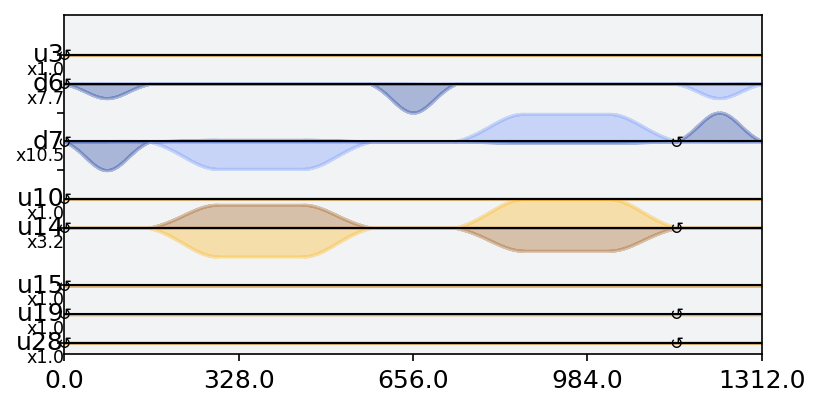

In [6]:
control,target=7,6
default_inst_map.get('cx',qubits=[control,target]).draw(style=style)

In [7]:
d = lambda qubit: pulse.DriveChannel(qubit)
c = lambda qubit: pulse.ControlChannel(qubit)
m = lambda qubit: pulse.MeasureChannel(qubit) 
a = lambda qubit: pulse.AcquireChannel(qubit)
mem_slot = lambda qubit: pulse.MemorySlot(qubit)

# Sweep CR Amplitude

In [11]:
test_scheds=[]
amplitude_scales=np.linspace(-1.0,1.0,70)
for ii,amp_scale in enumerate(amplitude_scales):
    q1=6
    q2=7
    # Extract default for reference
    cx_sched = default_inst_map.get('cx', qubits=(q1, q2))
    


    theta=0
    crs = []
    comp_tones = []
    shift_phases = []
    for time, inst in cx_sched.instructions:
        if isinstance(inst, ShiftPhase)and time == 0:
            shift_phases.append(ShiftPhase(theta, inst.channel))

        # Identify the CR pulses.
        if isinstance(inst, Play) and not isinstance(inst, ShiftPhase):
            if isinstance(inst.channel, ControlChannel):
                crs.append((time, inst))

        # Identify the compensation tones.
        if isinstance(inst.channel, DriveChannel) and not isinstance(inst, ShiftPhase):
            if isinstance(inst.pulse, GaussianSquare):
                comp_tones.append((time, inst))
                target = inst.channel.index
                control = q1 if target == q2 else q2

    # Id the X90 gate at the start
    x90 = cx_sched.filter(time_ranges=[(0, crs[0][0])], channels=[DriveChannel(target)]).instructions
    x90 = x90[0][1]
    echo_x = default_inst_map.get('x', qubits=control)

    #####--------------------WHERE WE WILL BUILD SCHEDULE WITH DIFFERENT PARAMETERS-------------------------
    # Build the schedule
    zx_theta = Schedule(name="Test")
    for inst in shift_phases:
        zx_theta = zx_theta.insert(0, inst)
    initial_X = cx_sched.instructions[4][1]
    cxy_gate0 = default_inst_map.get('u1',P0=-theta, qubits=control)
    time = zx_theta.duration
    zx_theta = zx_theta.insert(time, cxy_gate0)
    time = zx_theta.duration
    zx_theta = zx_theta.insert(0, echo_x.instructions[0][1])
    # zx_theta = zx_theta.insert(0, x90)

    # Stretch/compress the CR gates and compensation tones
    cr1 = crs[0][1]
    cr2 = crs[1][1]
    cr_width = cr1.pulse.width
    cr1_amp = cr1.pulse.amp
    cr2_amp = cr2.pulse.amp
    cr_sigma = cr1.pulse.sigma
    cr_duration = cr1.pulse.duration
    cr_channel = cr1.channel
    cr1_new = Play(GaussianSquare(amp=amp_scale, width=cr_width, sigma=cr_sigma, duration=cr_duration),
                channel=cr_channel)
    cr2_new = Play(GaussianSquare(amp=-1.0*amp_scale, width=cr_width, sigma=cr_sigma, duration=cr_duration),
                channel=cr_channel)

    comp1 = comp_tones[0][1]
    comp2 = comp_tones[1][1]

    zx_theta = zx_theta.insert(crs[0][0], cr1_new)
    zx_theta = zx_theta.insert(comp_tones[0][0] + comp1.duration, echo_x)
    time = comp_tones[0][0] + comp1.duration + echo_x.duration
    zx_theta = zx_theta.insert(time, cr2_new)
    zx_theta |= default_inst_map.get('measure',qubits=np.arange(0,20,1))<<zx_theta.duration
    test_scheds.append(zx_theta)

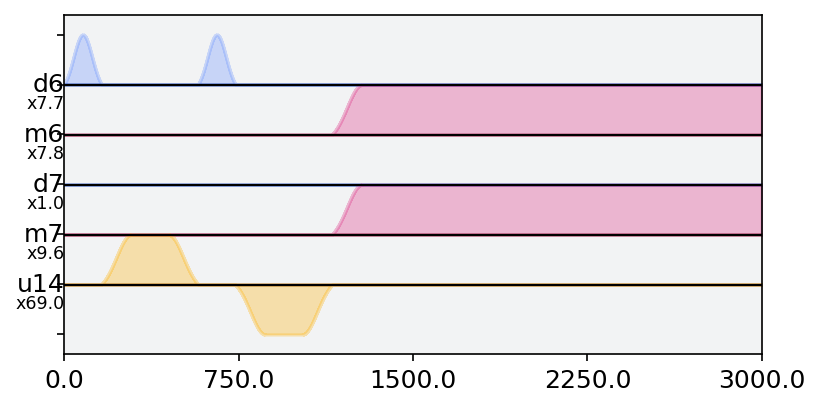

In [12]:
test_scheds[35].draw(style=style,channels=[d(6),d(7),c(14),m(6),m(7)],plot_range=[0,3000])

In [54]:
num_shots_per_frequency = 1024
test_qobj = assemble(test_scheds,
                   backend=backend, 
                   meas_level=2,
                   meas_return='avg',
                   shots=num_shots_per_frequency)
job = backend.run(test_qobj)
print ("job.job_id()")

5fda8143f4603d001a144700


In [56]:
# 5fda8143f4603d001a144700
job.status()

<JobStatus.DONE: 'job has successfully run'>


In [57]:
test_result = job.result()

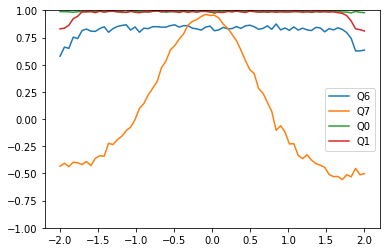

In [58]:
job_results = backend.retrieve_job("5fda8143f4603d001a144700").result()
counts = job_results.get_counts()
idxs = np.arange(0,20,1)#[0,1,2,3,4]
Q6 = []
Q7 = []

Q0 = []
Q1 = []
for ii,circ in enumerate(amplitude_scales):
    for jj,pt in enumerate(idxs):
        zero = 0
        one = 0
#         print ("Qubit %.0f"%(4-pt))
        expv = 0
        for key,val in counts[ii].items():
            if key[pt] == '1':
                expv -= val
            else:
                expv += val
        if jj==19:
            Q0.append(expv/1024)
        if jj==18:
            Q1.append(expv/1024)
        if jj==13:
            Q6.append(expv/1024)
        if jj==12:
            Q7.append(expv/1024)
plt.plot(amplitude_scales,Q6,label='Q6')
plt.plot(amplitude_scales,Q7,label='Q7')

plt.plot(amplitude_scales,Q0,label='Q0')
plt.plot(amplitude_scales,Q1,label='Q1')

plt.ylim(-1,1)
plt.legend()

# Sweep CR Phase

In [36]:
test0_scheds=[]
test1_scheds=[]
crphases=np.linspace(-np.pi,np.pi,70)
for ii,phase in enumerate(crphases):
    q1=6
    q2=7
    cx_sched = default_inst_map.get('cx', qubits=(q1, q2))



    theta=0
    crs = []
    comp_tones = []
    shift_phases = []
    control = None
    target = None
    for time, inst in cx_sched.instructions:
        if isinstance(inst, ShiftPhase)and time == 0:
            shift_phases.append(ShiftPhase(theta, inst.channel))

        # Identify the CR pulses.
        if isinstance(inst, Play) and not isinstance(inst, ShiftPhase):
            if isinstance(inst.channel, ControlChannel):
                crs.append((time, inst))

        # Identify the compensation tones.
        if isinstance(inst.channel, DriveChannel) and not isinstance(inst, ShiftPhase):
            if isinstance(inst.pulse, GaussianSquare):
                comp_tones.append((time, inst))
                target = inst.channel.index
                control = q1 if target == q2 else q2


    # Id the X90 gate at the start of the schedule and rescale it.
    x90 = cx_sched.filter(time_ranges=[(0, crs[0][0])], channels=[DriveChannel(target)]).instructions

    x90 = x90[0][1]

    echo_x = default_inst_map.get('x', qubits=control)
    initial_X = cx_sched.instructions[4][1]
    
###-----------------------------------------------    
    # Adjust CR gates
    cr1 = crs[0][1]
    cr2 = crs[1][1]
    cr_width = cr1.pulse.width
    cr1_amp = cr1.pulse.amp
    cr2_amp = cr2.pulse.amp
    cr_sigma = cr1.pulse.sigma
    cr_duration = cr1.pulse.duration
    cr_channel = cr1.channel
    cr1_new = Play(GaussianSquare(amp=cr1_amp*np.exp(-1j*phase), width=cr_width, sigma=cr_sigma, duration=cr_duration),
                channel=cr_channel)
    cr2_new = Play(GaussianSquare(amp=cr2_amp*np.exp(-1j*phase), width=cr_width, sigma=cr_sigma, duration=cr_duration),
                channel=cr_channel)

    zx_theta0 = Schedule(name="0Prep")
    zx_theta1 = Schedule(name="1Prep")
    # Build the 0 prep schedule
    for inst in shift_phases:
        zx_theta0 = zx_theta0.insert(0, inst)

#     time = zx_theta0.duration
    zx_theta0 = zx_theta0.insert(0, echo_x.instructions[0][1])
    # zx_theta = zx_theta.insert(0, x90)


    zx_theta0 = zx_theta0.insert(crs[0][0], cr1_new)
    zx_theta0 = zx_theta0.insert(cr1_new.duration+echo_x.duration, echo_x)
    time = cr1_new.duration + echo_x.duration*2
    zx_theta0 = zx_theta0.insert(time, cr2_new)
    ## Need to rotate target to Y basis
    zx_theta0 |= default_inst_map.get('u2',P0=0,P1=np.pi/2,qubits=[target])<<zx_theta0.duration
    zx_theta0 |= default_inst_map.get('measure',qubits=np.arange(0,20,1))<<zx_theta0.duration
    test0_scheds.append(zx_theta0)
###-----------------------------------------------
    # Build the 1 prep schedule
    zx_theta1 |= default_inst_map.get('x',qubits=control)
    time = zx_theta1.duration
    for inst in shift_phases:
        zx_theta1 = zx_theta1.insert(time, inst)
    time = zx_theta1.duration
    zx_theta1 = zx_theta1.insert(time, echo_x.instructions[0][1])
    time = zx_theta1.duration
    zx_theta1 = zx_theta1.insert(time, cr1_new)
    zx_theta1 = zx_theta1.insert(cr1_new.duration+2*echo_x.duration, echo_x)
    time = cr1_new.duration + echo_x.duration
    time = zx_theta1.duration
    zx_theta1 = zx_theta1.insert(time, cr2_new)
    ## Need to rotate target to Y basis
    zx_theta1 |= default_inst_map.get('u2',P0=0,P1=np.pi,qubits=[target])<<zx_theta1.duration
    zx_theta1 |= default_inst_map.get('measure',qubits=np.arange(0,20,1))<<zx_theta1.duration
    test1_scheds.append(zx_theta1)
    

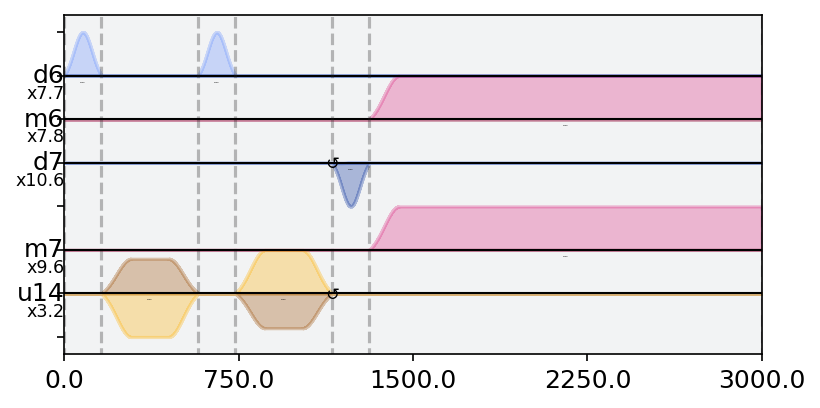

In [37]:
test0_scheds[0].draw(style=style,channels=[d(6),d(7),c(14),m(6),m(7)],plot_range=[0,3000],label=True)

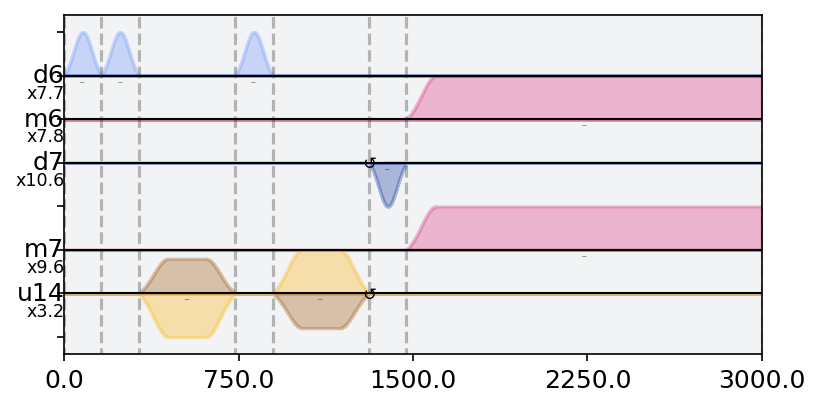

In [42]:
test1_scheds[0].draw(style=style,channels=[d(6),d(7),c(14),m(6),m(7)],plot_range=[0,3000],label=True)

In [416]:
num_shots_per_frequency = 1024
test_qobj = assemble(test0_scheds,
                   backend=backend, 
                   meas_level=2,
                   meas_return='avg',
                   shots=num_shots_per_frequency)
job = backend.run(test_qobj)
print (job.job_id())

5fdaa82d53716700199f578b


In [43]:
num_shots_per_frequency = 1024
test_qobj = assemble(test1_scheds,
                   backend=backend, 
                   meas_level=2,
                   meas_return='avg',
                   shots=num_shots_per_frequency)
job = backend.run(test_qobj)
print (job.job_id())

5fdb6fc9331ef50019e6a385


In [49]:
# 0 sched
#5fda9f493dcfe8001b85f369
#5fdaa82d53716700199f578b

# 1 sched
#5fdb6fc9331ef50019e6a385
job.status()

<JobStatus.DONE: 'job has successfully run'>

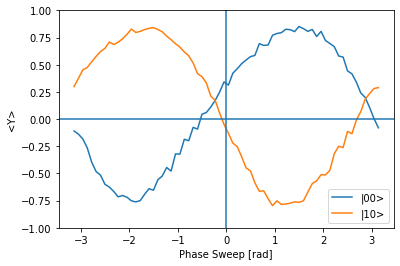

In [73]:
job_results = backend.retrieve_job("5fda9f493dcfe8001b85f369").result()
counts = job_results.get_counts()
idxs = np.arange(0,20,1)#[0,1,2,3,4]
Q6_0 = []
Q7_0 = []

Q0_0 = []
Q1_0 = []
for ii,circ in enumerate(crphases):
    for jj,pt in enumerate(idxs):
        zero = 0
        one = 0
#         print ("Qubit %.0f"%(4-pt))
        expv = 0
        for key,val in counts[ii].items():
            if key[pt] == '1':
                expv -= val
            else:
                expv += val
        if jj==19:
            Q0_0.append(expv/1024)
        if jj==18:
            Q1_0.append(expv/1024)
        if jj==13:
            Q6_0.append(expv/1024)
        if jj==12:
            Q7_0.append(expv/1024)
            
job_results = backend.retrieve_job("5fdb6fc9331ef50019e6a385").result()
counts = job_results.get_counts()
idxs = np.arange(0,20,1)#[0,1,2,3,4]
Q6_1 = []
Q7_1 = []

Q0_1 = []
Q1_1 = []
for ii,circ in enumerate(crphases):
    for jj,pt in enumerate(idxs):
        zero = 0
        one = 0
#         print ("Qubit %.0f"%(4-pt))
        expv = 0
        for key,val in counts[ii].items():
            if key[pt] == '1':
                expv -= val
            else:
                expv += val
        if jj==19:
            Q0_1.append(expv/1024)
        if jj==18:
            Q1_1.append(expv/1024)
        if jj==13:
            Q6_1.append(expv/1024)
        if jj==12:
            Q7_1.append(expv/1024)
            

# plt.plot(crphases,Q6_0,label='Q6_0')
plt.plot(crphases,Q7_0,label='|00>')

# plt.plot(crphases,Q0_0,label='Q0_0')
# plt.plot(crphases,Q1_0,label='Q1_0')

# plt.plot(crphases,Q6_1,label='Q6_1')
plt.plot(crphases,Q7_1,label='|10>')

# plt.plot(crphases,Q0_1,label='Q0_1')
# plt.plot(crphases,Q1_1,label='Q1_1')
plt.ylabel("<Y>")
plt.xlabel("Phase Sweep [rad]")
plt.ylim(-1,1)
plt.axvline(0.0)
plt.axhline(0.0)
plt.legend()

# Sweep Compensation Tone Amp

In [16]:
test_scheds=[]
amplitude_scales=np.linspace(-1.0,1.0,70)
for ii,amp_scale in enumerate(amplitude_scales):
    q1=6
    q2=7
    # Extract default for reference
    cx_sched = default_inst_map.get('cx', qubits=(q1, q2))
    


    theta=0
    crs = []
    comp_tones = []
    shift_phases = []
    for time, inst in cx_sched.instructions:
        if isinstance(inst, ShiftPhase)and time == 0:
            shift_phases.append(ShiftPhase(theta, inst.channel))

        # Identify the CR pulses.
        if isinstance(inst, Play) and not isinstance(inst, ShiftPhase):
            if isinstance(inst.channel, ControlChannel):
                crs.append((time, inst))

        # Identify the compensation tones.
        if isinstance(inst.channel, DriveChannel) and not isinstance(inst, ShiftPhase):
            if isinstance(inst.pulse, GaussianSquare):
                comp_tones.append((time, inst))
                target = inst.channel.index
                control = q1 if target == q2 else q2

    # Id the X90 gate at the start
    x90 = cx_sched.filter(time_ranges=[(0, crs[0][0])], channels=[DriveChannel(target)]).instructions
    x90 = x90[0][1]
    echo_x = default_inst_map.get('x', qubits=control)

    #####--------------------WHERE WE WILL BUILD SCHEDULE WITH DIFFERENT PARAMETERS-------------------------
    # Build the schedule
    zx_theta = Schedule(name="Test")
    for inst in shift_phases:
        zx_theta = zx_theta.insert(0, inst)
    initial_X = cx_sched.instructions[4][1]
    cxy_gate0 = default_inst_map.get('u1',P0=-theta, qubits=control)
    time = zx_theta.duration
    zx_theta = zx_theta.insert(time, cxy_gate0)
    time = zx_theta.duration
    zx_theta = zx_theta.insert(0, echo_x.instructions[0][1])
    # zx_theta = zx_theta.insert(0, x90)

    # Stretch/compress the CR gates and compensation tones
    cr1 = crs[0][1]
    cr2 = crs[1][1]
    comp1 = comp_tones[0][1]
    comp2 = comp_tones[1][1]
    comp1_width = comp1.pulse.width
    comp1_amp = comp1.pulse.amp
    comp2_amp = comp2.pulse.amp
    comp1_sigma = comp1.pulse.sigma
    comp1_duration = comp1.pulse.duration
    comp1_channel = comp1.channel
    comp1_new = Play(GaussianSquare(amp=amp_scale, width=comp1_width, sigma=comp1_sigma, duration=comp1_duration),
                channel=comp1_channel)
    comp2_new = Play(GaussianSquare(amp=-1.0*amp_scale, width=comp1_width, sigma=comp1_sigma, duration=comp1_duration),
                channel=comp1_channel)

    

    zx_theta = zx_theta.insert(crs[0][0], cr1)
    zx_theta = zx_theta.insert(crs[0][0], comp1_new)
    zx_theta = zx_theta.insert(comp_tones[0][0] + comp1.duration, echo_x)
    time = comp_tones[0][0] + comp1.duration + echo_x.duration
    zx_theta = zx_theta.insert(time, cr2)
    zx_theta = zx_theta.insert(time, comp2_new)
    zx_theta |= default_inst_map.get('measure',qubits=np.arange(0,20,1))<<zx_theta.duration
    test_scheds.append(zx_theta)

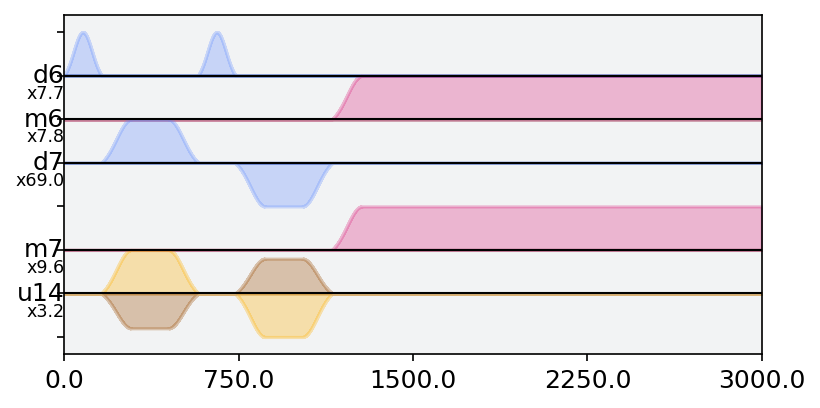

In [19]:
test_scheds[35].draw(style=style,channels=[d(6),d(7),c(14),m(6),m(7)],plot_range=[0,3000])